In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from pykalman import KalmanFilter

In [198]:
def pair_list_sort (pair_data, price_df, idx = 0):

    df_formation = price_df.loc[performance_test[idx][0]:performance_test[idx][1]]
    df_trading = price_df.loc[performance_test[idx][1]:performance_test[idx][2]]

    pair_list = []
    for x in pair_data[idx][0]:
        if x == []:
            pass
        else:
            for pair in x:
                pair_list.append(pair)

    return pair_list, df_formation, df_trading

def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    
    spread_lag2 = sm.add_constant(spread_lag)
     
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
 
    if halflife <= 0:
        halflife = 1
    return halflife

def getError(theta, state_covs, latest_prices):

    vt = 1e-3
    P = np.zeros((2, 2))
    R = state_covs
    F = np.asarray([latest_prices[0], 1.0]).reshape((1, 2))
    y = latest_prices[1]
    yhat = F.dot(theta)
    et = y - yhat
    Qt = F.dot(R).dot(F.T) + vt
    sqrt_Qt = np.sqrt(Qt)
    return et, sqrt_Qt

def getUpdate(theta, state_covs, latest_prices):
    delta = 1e-4
    wt = delta / (1 - delta) * np.eye(2)
    vt = 1e-3

    P = np.zeros((2, 2))
    R = state_covs

    F = np.asarray([latest_prices[0], 1.0]).reshape((1, 2))
    y = latest_prices[1]
    yhat = F.dot(theta)
    et = y - yhat
    Qt = F.dot(R).dot(F.T) + vt
    sqrt_Qt = np.sqrt(Qt)
    At = R.dot(F.T) / Qt
    new_theta = theta + At.flatten() * et
    C = R - At * F.dot(R)
    new_R = C + wt
    
    return new_theta, new_R

In [493]:
def reg_df_cal (df, entryz = 0.5, exitz = 0):
    
    df1 = df
    # Set up num units long             
    df1['long entry'] = ((df1.z < - entryz) & ( df1.z.shift(1) > - entryz))
    df1['long exit'] = ((df1.z > - exitz) & (df1.z.shift(1) < - exitz)) 
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    # Set up num units short 
    df1['short entry'] = ((df1.z >  entryz) & ( df1.z.shift(1) < entryz))
    df1['short exit'] = ((df1.z < exitz) & (df1.z.shift(1) > exitz))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hedge_ratio'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * np.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0

    df = df1

    return df

def reg_sharpe_cal (df, entryz = 0.5, exitz = 0):
    
    df1 = df
    # Set up num units long             
    df1['long entry'] = ((df1.z < - entryz) & ( df1.z.shift(1) > - entryz))
    df1['long exit'] = ((df1.z > - exitz) & (df1.z.shift(1) < - exitz)) 
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    # Set up num units short 
    df1['short entry'] = ((df1.z >  entryz) & ( df1.z.shift(1) < entryz))
    df1['short exit'] = ((df1.z < exitz) & (df1.z.shift(1) > exitz))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1['x'] * abs(df1['hedge_ratio'])) + df1['y'])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1) 

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * np.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0

    return sharpe

In [1027]:
def reg_df_cal_std (df, entry = 0.5, exit = 0):
    
    df1 = df
    # Set up num units long             
    df1['long entry'] = ((df1.stdev < - entry) & ( df1.stdev.shift(1) > - entry))
    df1['long exit'] = ((df1.stdev > - exit) & (df1.stdev.shift(1) < - exit)) 
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    # Set up num units short 
    df1['short entry'] = ((df1.stdev >  entry) & ( df1.stdev.shift(1) < entry))
    df1['short exit'] = ((df1.stdev < exit) & (df1.stdev.shift(1) > exit))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1[df1.columns[0]] * abs(df1['kal_beta'])) + df1[df1.columns[1]])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * np.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0

    df = df1

    return df

def reg_sharpe_cal_std (df, entry = 0.5, exit = 0):
    
    df1 = df
    # Set up num units long             
    df1['long entry'] = ((df1.stdev < - entry) & ( df1.stdev.shift(1) > - entry))
    df1['long exit'] = ((df1.stdev > - exit) & (df1.stdev.shift(1) < - exit)) 
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    # Set up num units short 
    df1['short entry'] = ((df1.stdev >  entry) & ( df1.spread.shift(1) < entry))
    df1['short exit'] = ((df1.stdev < exit) & (df1.stdev.shift(1) > exit))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1[df1.columns[0]] * abs(df1['kal_beta'])) + df1[df1.columns[1]])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1) 

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * np.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0

    return sharpe



In [1091]:
df_t = df_t[df_t.columns[0:5]]
tr_cal = df_t

In [1092]:
tr_cal

tic,SPTM,SCHX,kal_beta,stdev
Date,,,,
2020-01-02,38.396206,37.069489,0.941199,0.052568
2020-01-03,38.166859,36.816017,0.940233,-0.037159
2020-01-06,38.300652,36.954712,0.940561,0.012647
2020-01-07,38.195530,36.863846,0.940771,0.008092
2020-01-08,38.357990,37.031231,0.941149,0.014602
...,...,...,...,...
2020-12-24,44.392643,43.973625,0.969834,-0.000389
2020-12-28,44.733746,44.237110,0.968335,-0.067330
2020-12-29,44.607044,44.124882,0.968561,0.010128


In [1174]:
def reg_df_cal_std_tr (df, entry = 0.5, exit = 0, tr=0.25):
    
    df1 = df
    # Set up num units long             
    df1['long entry'] = ((df1.stdev < - entry) & ( df1.stdev.shift(1) > - entry))
    df1['long exit'] = ((df1.stdev > - exit) & (df1.stdev.shift(1) < - exit)) 
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    # Set up num units short 
    df1['short entry'] = ((df1.stdev >  entry) & ( df1.stdev.shift(1) < entry))
    df1['short exit'] = ((df1.stdev < exit) & (df1.stdev.shift(1) > exit))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1[df1.columns[0]] * abs(df1['kal_beta'])) + df1[df1.columns[1]])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1) * (1 - tr)

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * np.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0

    df = df1

    return df

def reg_sharpe_cal_std_tr (df, entry = 0.5, exit = 0, tr=0.25):
    
    df1 = df
    # Set up num units long             
    df1['long entry'] = ((df1.stdev < - entry) & ( df1.stdev.shift(1) > - entry))
    df1['long exit'] = ((df1.stdev > - exit) & (df1.stdev.shift(1) < - exit)) 
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad')

    # Set up num units short 
    df1['short entry'] = ((df1.stdev >  entry) & ( df1.stdev.shift(1) < entry))
    df1['short exit'] = ((df1.stdev < exit) & (df1.stdev.shift(1) > exit))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short'] 
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / ((df1[df1.columns[0]] * abs(df1['kal_beta'])) + df1[df1.columns[1]])
    df1['port rets'] = df1['spread pct ch'] * df1['numUnits'].shift(1) * (1 - tr)

    df1['cum rets'] = df1['port rets'].cumsum()
    df1['cum rets'] = df1['cum rets'] + 1

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * np.sqrt(252)) 
    except ZeroDivisionError:
        sharpe = 0.0

    return sharpe

In [112]:
monthly = pd.date_range('2009-12-31', '2022-1-1', freq='MS')

period_candi = [(3,1),(6,1),(12,1),(24,12)]

formation_train = {}
for cnd in period_candi:

    train_window_width = cnd[0]
    test_window_width = cnd[1]

    train_period = []
    test_period = []
    for i in range(len(monthly)- train_window_width-test_window_width):
        train_start_date = monthly[i]
        train_end_date = monthly[i+train_window_width]
        test_end_date = monthly[i+train_window_width+test_window_width]

        if test_end_date.year < 2017:

            train_period.append((train_start_date.strftime("%Y-%m-%d"), train_end_date.strftime("%Y-%m-%d"), test_end_date.strftime("%Y-%m-%d")))
        
        elif test_end_date.year >=2017:

            test_period.append((train_start_date.strftime("%Y-%m-%d"), train_end_date.strftime("%Y-%m-%d"), test_end_date.strftime("%Y-%m-%d")))
            
    formation_train[cnd] = (train_period, test_period)

performance_test = formation_train[(24,12)][1][48:60]
performance_test

[('2018-01-01', '2020-01-01', '2021-01-01'),
 ('2018-02-01', '2020-02-01', '2021-02-01'),
 ('2018-03-01', '2020-03-01', '2021-03-01'),
 ('2018-04-01', '2020-04-01', '2021-04-01'),
 ('2018-05-01', '2020-05-01', '2021-05-01'),
 ('2018-06-01', '2020-06-01', '2021-06-01'),
 ('2018-07-01', '2020-07-01', '2021-07-01'),
 ('2018-08-01', '2020-08-01', '2021-08-01'),
 ('2018-09-01', '2020-09-01', '2021-09-01'),
 ('2018-10-01', '2020-10-01', '2021-10-01'),
 ('2018-11-01', '2020-11-01', '2021-11-01'),
 ('2018-12-01', '2020-12-01', '2021-12-01')]

In [113]:
price_df = pd.read_csv('./Data/us_etf_price.csv', parse_dates=['Date'])
price_df = price_df.pivot(columns='tic', values='Adj Close', index='Date')
etf_info = pd.read_csv('./Data/etfs_details_equity.csv')

pair_data = pd.read_pickle('2020~2021_pair_reg.pkl')
pair_list, df_form, df_trade = pair_list_sort(pair_data, price_df, 0)
pair_list

[('SPDN', 'SH'), ('SPY', 'IVV'), ('VONE', 'VV'), ('SPLG', 'SCHX')]

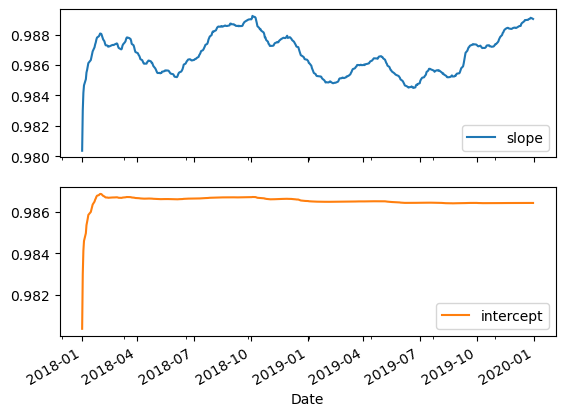

In [240]:
pair = pair_list[3]

df_f = df_form.loc[:, pair]
df_t = df_trade.loc[:, pair]

#np.cumprod(1 + df_f, axis=1)
delta = 1e-5
trans_cov = delta / (1-delta) * np.eye(2)
obs_mat = np.vstack([df_f[pair[0]], np.ones(len(df_f))]).T[:, np.newaxis]

kf = KalmanFilter(
    n_dim_obs=1, 
    n_dim_state=2,
    initial_state_mean=np.zeros(2),
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=1.0,
    transition_covariance=trans_cov
)

state_means, state_covs = kf.filter(df_f[pair[1]])

pd.DataFrame(
    dict(
        slope = state_means[:,0],
        intercept = state_means[:, 1],
    ), index=df_f.index
).plot(subplots=True)
plt.show()

Update 칼만 예측치 새로운 가격데이터를 이용해, 그리고 예측의 error를 생각

선택된 페어의 Formation 기간의 OLS static 헷지비율과, Kalman update 헷지 비율을 분석

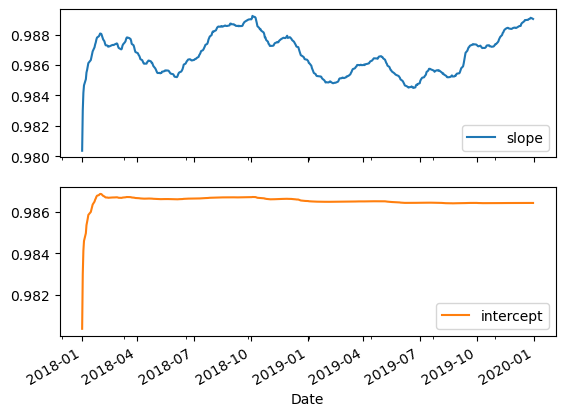

tic,SPLG,SCHX,log_SPLG,log_SCHX,error_kal,beta_kal,beta_ols,kal_spread,ols_spread
Date,,,,,,,,,
2020-01-02,36.459435,37.069489,3.596200,3.612794,0.023953,0.989672,0.995695,-0.017823,-0.010114
2020-01-03,36.230003,36.816017,3.589888,3.605933,-0.026195,0.988955,0.995695,-0.018577,-0.009962
2020-01-06,36.344719,36.954712,3.593049,3.609693,0.025050,0.989638,0.995695,-0.017874,-0.010128
2020-01-07,36.249126,36.863846,3.590415,3.607231,0.003923,0.989746,0.995695,-0.017781,-0.010176
2020-01-08,36.440311,37.031231,3.595676,3.611762,-0.021810,0.989152,0.995695,-0.018346,-0.009973
...,...,...,...,...,...,...,...,...,...
2020-12-24,42.283478,43.973625,3.744396,3.783590,-0.047112,1.016987,0.995695,0.012014,-0.016097
2020-12-28,42.634293,44.237110,3.752659,3.789564,-0.093550,1.014803,0.995695,0.009790,-0.015480
2020-12-29,42.546581,44.124882,3.750600,3.787024,-0.023727,1.014249,0.995695,0.009171,-0.015356


In [385]:
pair = pair_list[3]

df_f = df_form.loc[:, pair]
df_t = df_trade.loc[:, pair]

df_t[f'log_{pair[0]}'] = np.log(df_t[pair[0]])
df_t[f'log_{pair[1]}'] = np.log(df_t[pair[1]])

#np.cumprod(1 + df_f, axis=1)
delta = 1e-5
trans_cov = delta / (1-delta) * np.eye(2)
obs_mat = np.vstack([df_f[pair[0]], np.ones(len(df_f))]).T[:, np.newaxis]

kf = KalmanFilter(
    n_dim_obs=1, 
    n_dim_state=2,
    initial_state_mean=np.zeros(2),
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=1.0,
    transition_covariance=trans_cov
)

state_means, state_covs = kf.filter(df_f[pair[1]])

pd.DataFrame(
    dict(
        slope = state_means[:,0],
        intercept = state_means[:, 1],
    ), index=df_f.index
).plot(subplots=True)
plt.show()

state_means_new = []
state_means_new.append(state_means[-1])
state_covs_new = []
state_covs_new.append(state_covs[-1])
error_list = []
stdev_list = []

for idx in df_t.index:
    #idx = df_t.index[0]
    new_price_1 = df_t.loc[idx, pair[0]]
    new_price_2 = df_t.loc[idx, pair[1]]

    my_error, my_stdev = getError(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])
    my_new_theta, my_new_R = getUpdate(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])

    state_means_new.append(my_new_theta)
    state_covs_new.append(my_new_R)
    error_list.append(my_error)
    stdev_list.append(my_stdev[0])

neg_stdev_list = []
for s in stdev_list:
    neg_stdev_list.append(s*-1)

df_t['error_kal'] = [x.item() for x in error_list]
df_t['beta_kal'] = [x[0].item() for x in state_means_new[1:]]

x = sm.add_constant(df_f[pair[0]])
y = df_f[pair[1]]
reg = sm.OLS(y, x).fit()

beta, intercept = reg.params[1], reg.params[0]

df_t['beta_ols'] = [ beta for x in df_t.index]

''' pair1 매수, pair2 매도한 스프레드 '''

df_t['kal_spread'] = np.log(df_t[f'log_{pair[0]}']) * df_t['beta_kal'] - np.log(df_t[f'log_{pair[1]}'])
df_t['ols_spread'] = np.log(df_t[f'log_{pair[0]}']) * df_t['beta_ols'] - np.log(df_t[f'log_{pair[1]}'])

df_t

## --------------------------------- 이건가? -----------------------------------

In [625]:
pair = pair_list[0]

df_f = df_form.loc[:, pair]
df_t = df_trade.loc[:, pair]

df_t[f'log_{pair[0]}'] = np.log(df_t[pair[0]])
df_t[f'log_{pair[1]}'] = np.log(df_t[pair[1]])

delta = 1e-5
trans_cov = delta / (1-delta) * np.eye(2)
obs_mat = np.vstack([df_f[pair[0]], np.ones(len(df_f))]).T[:, np.newaxis]

kf = KalmanFilter(
    n_dim_obs=1, 
    n_dim_state=2,
    initial_state_mean=np.zeros(2),
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=1.0,
    transition_covariance=trans_cov
)

state_means, state_covs = kf.filter(df_f[pair[1]])

state_means.shape

stdev_of_mean = (state_means[:,0] * df_f[pair[0]] - df_f[pair[1]]).std()

In [626]:
state_means_new = []
state_means_new.append(state_means[-1])
state_covs_new = []
state_covs_new.append(state_covs[-1])
error_list = []
stdev_list = []

kal_beta_arr = list(state_means[:,0])

for num, idx in enumerate(df_t.index):

    # idx = df_t.index[0]
    new_price_1 = df_t.loc[idx, pair[0]]
    new_price_2 = df_t.loc[idx, pair[1]]

    my_error, my_stdev = getError(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])
    my_new_theta, my_new_R = getUpdate(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])

    state_means_new.append(my_new_theta)
    state_covs_new.append(my_new_R)
    error_list.append(my_error)
    stdev_list.append(my_stdev[0])

    tmp = pd.concat([df_f, df_t.loc[:idx]], axis=0)
    
    kal_beta_arr.append(state_means_new[-1][0])

    updated_spread = tmp[pair[0]] * kal_beta_arr - tmp[pair[1]]
    normalized_value = (updated_spread - updated_spread.mean())/updated_spread.std()

    df_t.loc[idx,'z_kal_spread'] = normalized_value[-1]

neg_stdev_list = []
for s in stdev_list:
    neg_stdev_list.append(s*-1)

df_t['error_kal'] = [x.item() for x in error_list]
df_t['beta_kal'] = [x[0].item() for x in state_means_new[1:]]

x = sm.add_constant(df_f[pair[0]])
y = df_f[pair[1]]
reg = sm.OLS(y, x).fit()

beta, intercept = reg.params[1], reg.params[0]

df_t['beta_ols'] = [ beta for x in df_t.index]

''' pair1 매수, pair2 매도한 스프레드 '''

df_t['kal_spread'] = np.log(df_t[f'log_{pair[0]}']) * df_t['beta_kal'] - np.log(df_t[f'log_{pair[1]}'])
df_t['ols_spread'] = np.log(df_t[f'log_{pair[0]}']) * df_t['beta_ols'] - np.log(df_t[f'log_{pair[1]}'])

df_t['z_ols_spread'] = (df_t['ols_spread'] - df_t['ols_spread'].mean()) / df_t['ols_spread'].std()


df_t['z_kal_spread_after'] = (df_t['kal_spread'] - df_t['kal_spread'].mean()) / df_t['kal_spread'].std()

# plt.plot(df_t['kal_spread'], label='kal')
# plt.plot(df_t['ols_spread'], label='ols')
# plt.legend()
# plt.show()

In [627]:
df_t

tic,SPDN,SH,log_SPDN,log_SH,z_kal_spread,error_kal,beta_kal,beta_ols,kal_spread,ols_spread,z_ols_spread,z_kal_spread_after
Date,,,,,,,,,,,,
2020-01-02,24.160183,23.757460,3.184706,3.167897,-0.200099,-0.044297,0.943778,1.013303,-0.059834,0.020701,-1.527927,0.874533
2020-01-03,24.339813,23.937288,3.192113,3.175437,-0.225611,0.009694,0.944169,1.013303,-0.059564,0.020678,-1.567927,0.935181
2020-01-06,24.250000,23.857363,3.188417,3.172093,-0.223193,0.005031,0.944373,1.013303,-0.059368,0.020557,-1.773585,0.979290
2020-01-07,24.309877,23.917309,3.190883,3.174602,-0.222272,0.003482,0.944513,1.013303,-0.059266,0.020550,-1.786168,1.002390
2020-01-08,24.199104,23.797421,3.186316,3.169577,-0.210704,-0.015205,0.943897,1.013303,-0.059749,0.020683,-1.559264,0.893565
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,18.631676,18.209999,2.924863,2.901971,0.417041,0.022277,0.927059,1.013303,-0.070426,0.022135,0.920622,-1.510721
2020-12-28,18.491890,18.049999,2.917332,2.893146,0.484687,-0.029805,0.925506,1.013303,-0.071433,0.022568,1.660955,-1.737429
2020-12-29,18.531828,18.100000,2.919490,2.895912,0.437316,0.012216,0.926147,1.013303,-0.071018,0.022361,1.307956,-1.644093


In [628]:
cum_mean = np.cumsum(df_t.kal_spread.to_numpy()) / np.arange(1, len(df_t)+1)
aaa = (df_t.kal_spread - cum_mean) / stdev_of_mean

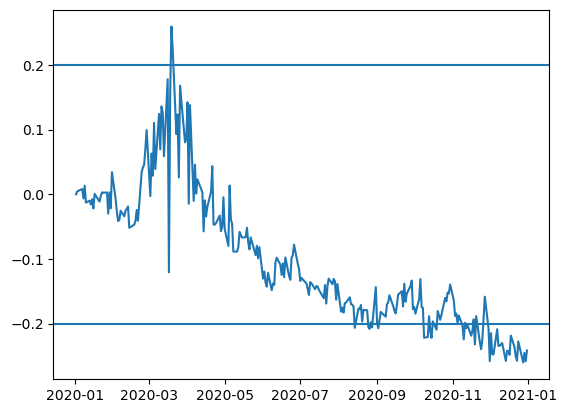

In [629]:
plt.plot(aaa)
plt.axhline(0.2)
plt.axhline(-0.2)

In [630]:
df_t['z'] = aaa

test_df = df_t[[f'log_{pair[0]}', f'log_{pair[1]}', 'kal_spread', 'z', 'beta_kal']]
test_df = test_df.rename(columns={'kal_spread': 'spread', f'log_{pair[0]}' : 'x', f'log_{pair[1]}' : 'y', 'beta_kal':'hedge_ratio'})

In [631]:
reg_df_cal(test_df, 0.2, -0.2)

/var/folders/0k/zyr795gx3hl6x1nytrrntcnc0000gn/T/ipykernel_97132/999620823.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['num units long'][0] = 0
/var/folders/0k/zyr795gx3hl6x1nytrrntcnc0000gn/T/ipykernel_97132/999620823.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['num units short'][0] = 0


tic,x,y,spread,z,hedge_ratio,long entry,long exit,num units long,short entry,short exit,num units short,numUnits,spread pct ch,port rets,cum rets
Date,,,,,,,,,,,,,,,
2020-01-02,3.184706,3.167897,-0.059834,0.000000,0.943778,False,False,0.0,False,False,0.0,0.0,NaN,NaN,NaN
2020-01-03,3.192113,3.175437,-0.059564,0.004489,0.944169,False,False,0.0,False,False,0.0,0.0,0.000044,0.000000,1.000000
2020-01-06,3.188417,3.172093,-0.059368,0.007346,0.944373,False,False,0.0,False,False,0.0,0.0,0.000032,0.000000,1.000000
2020-01-07,3.190883,3.174602,-0.059266,0.008074,0.944513,False,False,0.0,False,False,0.0,0.0,0.000017,0.000000,1.000000
2020-01-08,3.186316,3.169577,-0.059749,-0.006429,0.943897,False,False,0.0,False,False,0.0,0.0,-0.000078,-0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,2.924863,2.901971,-0.070426,-0.227654,0.927059,False,False,1.0,False,False,0.0,1.0,0.000155,0.000155,1.001907
2020-12-28,2.917332,2.893146,-0.071433,-0.260170,0.925506,False,False,1.0,False,False,0.0,1.0,-0.000180,-0.000180,1.001727
2020-12-29,2.919490,2.895912,-0.071018,-0.245371,0.926147,False,False,1.0,False,False,0.0,1.0,0.000074,0.000074,1.001801


In [632]:
reg_sharpe_cal(test_df, 0.2, -0.2)

/var/folders/0k/zyr795gx3hl6x1nytrrntcnc0000gn/T/ipykernel_97132/999620823.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['num units long'][0] = 0
/var/folders/0k/zyr795gx3hl6x1nytrrntcnc0000gn/T/ipykernel_97132/999620823.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['num units short'][0] = 0


0.7530220539917007

## --------------------------------------- ?? -------------------------------------------------

In [633]:
mean_list = []
for num in range(len(df_t)):
    a = np.mean(np.array(df_t.kal_spread)[:num])
    print(a)
    mean_list.append(a)

nan
-0.059833639593629195
-0.05969897677646585
-0.059588795792156445
-0.05950805967665601
-0.05955627205048786
-0.05947650795095242
-0.05954113157142116
-0.0595830866905632
-0.059642300074168896
-0.05966793019075951
-0.05973367022970331
-0.059732022425553664
-0.05976029000266322
-0.059765564412338455
-0.05975900900991856
-0.05975421083127527
-0.05974876667512318
-0.05980152445162021
-0.05979668991915933
-0.05983084791263713
-0.059779583757914395
-0.05979030491212139
-0.0598282503591745
-0.059882168260022406
-0.05993130147394845
-0.05996185709582895
-0.06000117454297454
-0.06002885501763371
-0.060053170937073984
-0.060072545778159694
-0.06012431922610614
-0.06016985951652373
-0.060208491799387996
-0.06023059853296857
-0.06026666484465163
-0.060237294710281705
-0.06020270449250563
-0.0601655126117835
-0.060109804466738574
-0.06003339850190801
-0.06003546340995777
-0.05998929433923364
-0.059968723537331334
-0.05989166644303311
-0.05986499284438841
-0.05978216457373888
-0.05973679934354589

/opt/homebrew/Caskroom/miniforge/base/envs/quant/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/envs/quant/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [634]:
mean_list

[nan,
 -0.059833639593629195,
 -0.05969897677646585,
 -0.059588795792156445,
 -0.05950805967665601,
 -0.05955627205048786,
 -0.05947650795095242,
 -0.05954113157142116,
 -0.0595830866905632,
 -0.059642300074168896,
 -0.05966793019075951,
 -0.05973367022970331,
 -0.059732022425553664,
 -0.05976029000266322,
 -0.059765564412338455,
 -0.05975900900991856,
 -0.05975421083127527,
 -0.05974876667512318,
 -0.05980152445162021,
 -0.05979668991915933,
 -0.05983084791263713,
 -0.059779583757914395,
 -0.05979030491212139,
 -0.0598282503591745,
 -0.059882168260022406,
 -0.05993130147394845,
 -0.05996185709582895,
 -0.06000117454297454,
 -0.06002885501763371,
 -0.060053170937073984,
 -0.060072545778159694,
 -0.06012431922610614,
 -0.06016985951652373,
 -0.060208491799387996,
 -0.06023059853296857,
 -0.06026666484465163,
 -0.060237294710281705,
 -0.06020270449250563,
 -0.0601655126117835,
 -0.060109804466738574,
 -0.06003339850190801,
 -0.06003546340995777,
 -0.05998929433923364,
 -0.059968723537331

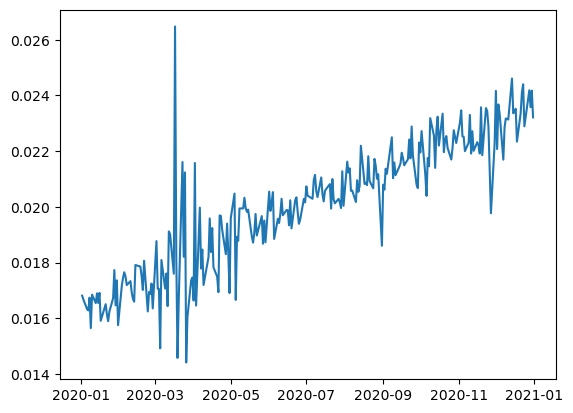

In [635]:
plt.plot(np.log(df_t[pair[0]]) - np.log(df_t[pair[1]]))

In [636]:
df_t

tic,SPDN,SH,log_SPDN,log_SH,z_kal_spread,error_kal,beta_kal,beta_ols,kal_spread,ols_spread,z_ols_spread,z_kal_spread_after,z
Date,,,,,,,,,,,,,
2020-01-02,24.160183,23.757460,3.184706,3.167897,-0.200099,-0.044297,0.943778,1.013303,-0.059834,0.020701,-1.527927,0.874533,0.000000
2020-01-03,24.339813,23.937288,3.192113,3.175437,-0.225611,0.009694,0.944169,1.013303,-0.059564,0.020678,-1.567927,0.935181,0.004489
2020-01-06,24.250000,23.857363,3.188417,3.172093,-0.223193,0.005031,0.944373,1.013303,-0.059368,0.020557,-1.773585,0.979290,0.007346
2020-01-07,24.309877,23.917309,3.190883,3.174602,-0.222272,0.003482,0.944513,1.013303,-0.059266,0.020550,-1.786168,1.002390,0.008074
2020-01-08,24.199104,23.797421,3.186316,3.169577,-0.210704,-0.015205,0.943897,1.013303,-0.059749,0.020683,-1.559264,0.893565,-0.006429
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,18.631676,18.209999,2.924863,2.901971,0.417041,0.022277,0.927059,1.013303,-0.070426,0.022135,0.920622,-1.510721,-0.227654
2020-12-28,18.491890,18.049999,2.917332,2.893146,0.484687,-0.029805,0.925506,1.013303,-0.071433,0.022568,1.660955,-1.737429,-0.260170
2020-12-29,18.531828,18.100000,2.919490,2.895912,0.437316,0.012216,0.926147,1.013303,-0.071018,0.022361,1.307956,-1.644093,-0.245371


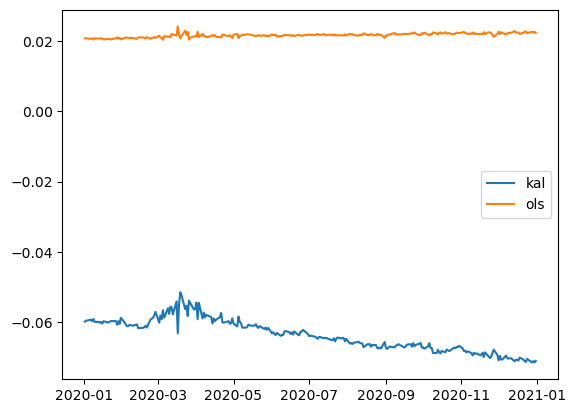

In [637]:
plt.plot(df_t['kal_spread'], label='kal')
plt.plot(df_t['ols_spread'], label='ols')
plt.legend()
plt.show()

In [638]:
arr = np.log(df_t[pair[0]].to_numpy()) - np.log(df_t[pair[1]].to_numpy())

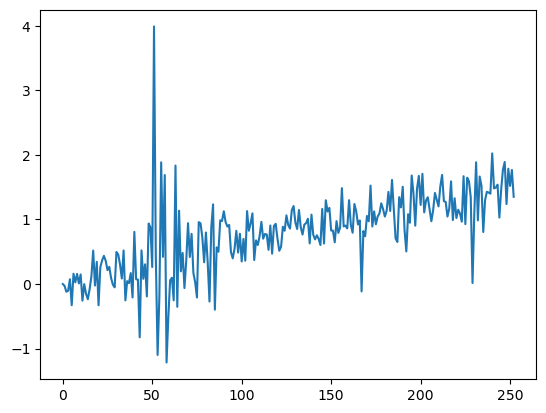

In [639]:
# 누적 평균 spread 
cum_mean_spread = np.cumsum(arr) / np.arange(1, len(arr)+1)

plt.plot((arr - cum_mean_spread) / arr.std())

In [640]:
for x in df_t.index:
    a = np.log(df_t[[pair[0]]]) - np.log(df_t[[pair[1]]])


[]

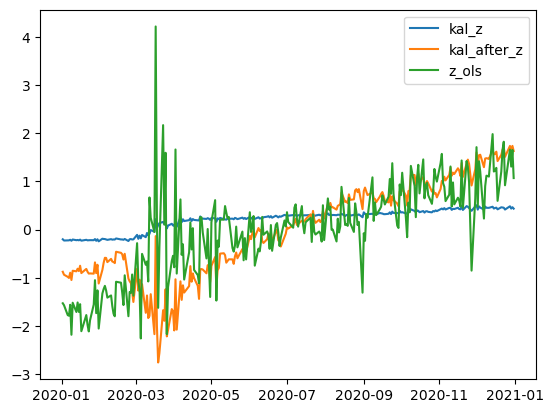

In [641]:
plt.plot(df_t.z_kal_spread, label='kal_z')
plt.plot(-df_t.z_kal_spread_after, label='kal_after_z')
plt.plot(df_t.z_ols_spread, label='z_ols')
plt.legend()
plt.plot()

In [642]:
df_t.z_ols_spread

Date
2020-01-02   -1.527927
2020-01-03   -1.567927
2020-01-06   -1.773585
2020-01-07   -1.786168
2020-01-08   -1.559264
                ...   
2020-12-24    0.920622
2020-12-28    1.660955
2020-12-29    1.307956
2020-12-30    1.654218
2020-12-31    1.070169
Name: z_ols_spread, Length: 253, dtype: float64

In [643]:
df_t.z_kal_spread_after

Date
2020-01-02    0.874533
2020-01-03    0.935181
2020-01-06    0.979290
2020-01-07    1.002390
2020-01-08    0.893565
                ...   
2020-12-24   -1.510721
2020-12-28   -1.737429
2020-12-29   -1.644093
2020-12-30   -1.738073
2020-12-31   -1.631757
Name: z_kal_spread_after, Length: 253, dtype: float64

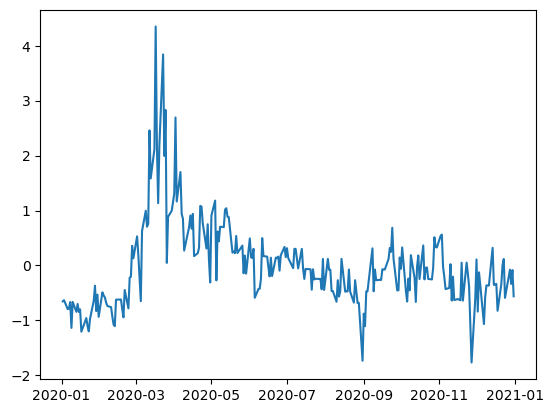

In [644]:
plt.plot(df_t.z_ols_spread + df_t.z_kal_spread_after)

In [645]:
state_means_new = []
state_means_new.append(state_means[-1])
state_covs_new = []
state_covs_new.append(state_covs[-1])
error_list = []
stdev_list = []

for idx in df_t.index:
    #idx = df_t.index[0]
    new_price_1 = df_t.loc[idx, pair[0]]
    new_price_2 = df_t.loc[idx, pair[1]]

    my_error, my_stdev = getError(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])
    my_new_theta, my_new_R = getUpdate(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])

    state_means_new.append(my_new_theta)
    state_covs_new.append(my_new_R)
    error_list.append(my_error)
    stdev_list.append(my_stdev[0])

neg_stdev_list = []
for s in stdev_list:
    neg_stdev_list.append(s*-1)

df_t['error_kal'] = [x.item() for x in error_list]
df_t['beta_kal'] = [x[0].item() for x in state_means_new[1:]]

x = sm.add_constant(df_f[pair[0]])
y = df_f[pair[1]]
reg = sm.OLS(y, x).fit()

beta, intercept = reg.params[1], reg.params[0]

df_t['beta_ols'] = [ beta for x in df_t.index]

''' pair1 매수, pair2 매도한 스프레드 '''

df_t['kal_spread'] = np.log(df_t[f'log_{pair[0]}']) * df_t['beta_kal'] - np.log(df_t[f'log_{pair[1]}'])
df_t['ols_spread'] = np.log(df_t[f'log_{pair[0]}']) * df_t['beta_ols'] - np.log(df_t[f'log_{pair[1]}'])

df_t

tic,SPDN,SH,log_SPDN,log_SH,z_kal_spread,error_kal,beta_kal,beta_ols,kal_spread,ols_spread,z_ols_spread,z_kal_spread_after,z
Date,,,,,,,,,,,,,
2020-01-02,24.160183,23.757460,3.184706,3.167897,-0.200099,-0.044297,0.943778,1.013303,-0.059834,0.020701,-1.527927,0.874533,0.000000
2020-01-03,24.339813,23.937288,3.192113,3.175437,-0.225611,0.009694,0.944169,1.013303,-0.059564,0.020678,-1.567927,0.935181,0.004489
2020-01-06,24.250000,23.857363,3.188417,3.172093,-0.223193,0.005031,0.944373,1.013303,-0.059368,0.020557,-1.773585,0.979290,0.007346
2020-01-07,24.309877,23.917309,3.190883,3.174602,-0.222272,0.003482,0.944513,1.013303,-0.059266,0.020550,-1.786168,1.002390,0.008074
2020-01-08,24.199104,23.797421,3.186316,3.169577,-0.210704,-0.015205,0.943897,1.013303,-0.059749,0.020683,-1.559264,0.893565,-0.006429
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,18.631676,18.209999,2.924863,2.901971,0.417041,0.022277,0.927059,1.013303,-0.070426,0.022135,0.920622,-1.510721,-0.227654
2020-12-28,18.491890,18.049999,2.917332,2.893146,0.484687,-0.029805,0.925506,1.013303,-0.071433,0.022568,1.660955,-1.737429,-0.260170
2020-12-29,18.531828,18.100000,2.919490,2.895912,0.437316,0.012216,0.926147,1.013303,-0.071018,0.022361,1.307956,-1.644093,-0.245371


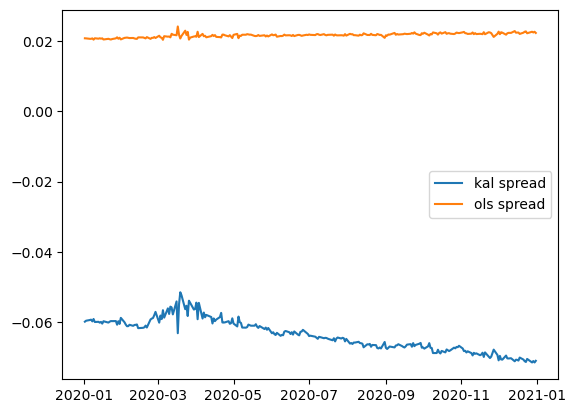

In [646]:
plt.plot(df_t['kal_spread'], label='kal spread')
plt.plot(df_t['ols_spread'], label='ols spread')
plt.legend()
plt.show()

In [647]:
#plt.plot((df_t[pair[1]] - df_t[pair[0]]) - (df_t[pair[1]] - df_t[pair[0]]).mean(), label='Mean Spread')
#plt.plot(df_t['error'], label='K Error')
plt.plot(df_t['new_mean'])
plt.axhline(beta)
plt.legend()
plt.show()

KeyError: 'new_mean'

In [ ]:
neg_stdev_list

[array([-0.60491521]),
 array([-1.41958723]),
 array([-1.42362018]),
 array([-1.42045343]),
 array([-1.42764806]),
 array([-1.43694732]),
 array([-1.43301041]),
 array([-1.4436577]),
 array([-1.4417345]),
 array([-1.44432476]),
 array([-1.45669553]),
 array([-1.46081345]),
 array([-1.45774257]),
 array([-1.45937399]),
 array([-1.46090784]),
 array([-1.44728913]),
 array([-1.42600508]),
 array([-1.44040068]),
 array([-1.43885895]),
 array([-1.442792]),
 array([-1.41871875]),
 array([-1.42975877]),
 array([-1.45123659]),
 array([-1.46494021]),
 array([-1.46992056]),
 array([-1.46310885]),
 array([-1.47308657]),
 array([-1.47653468]),
 array([-1.48660291]),
 array([-1.48525538]),
 array([-1.48803714]),
 array([-1.48487113]),
 array([-1.49254511]),
 array([-1.48822583]),
 array([-1.47096544]),
 array([-1.4222567]),
 array([-1.38027286]),
 array([-1.37261888]),
 array([-1.31192242]),
 array([-1.30331784]),
 array([-1.36096846]),
 array([-1.32113154]),
 array([-1.37745323]),
 array([-1.33234

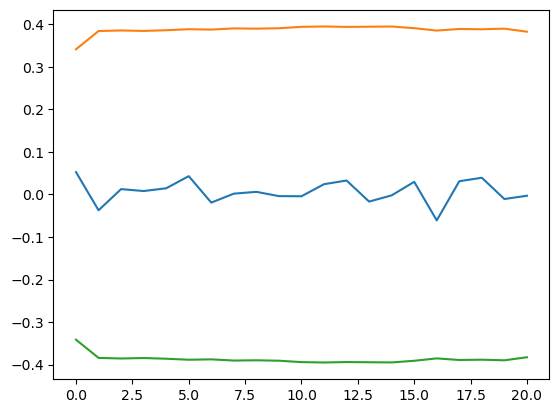

In [ ]:
plt.plot(error_list)
plt.plot(stdev_list)
plt.plot(neg_stdev_list)
plt.show()

In [ ]:
half_life(df_t.ratio)

AttributeError: 'DataFrame' object has no attribute 'ratio'

In [ ]:
df_t['mean'] = mean.squeeze()
df_t['cov'] = cov.squeeze()
df_t['std'] = np.sqrt(df_t['cov'])

hal
(df_t['ratio'].rolling(5).mean() - df_t['mean']) / df_t['std']

Date
2020-01-02         NaN
2020-01-03         NaN
2020-01-06         NaN
2020-01-07         NaN
2020-01-08    0.421480
2020-01-09    0.390033
2020-01-10    0.364750
2020-01-13    0.343626
2020-01-14    0.325834
2020-01-15    0.310693
2020-01-16    0.297227
2020-01-17    0.285068
2020-01-21    0.274312
2020-01-22    0.264729
2020-01-23    0.255782
2020-01-24    0.247817
2020-01-27    0.240894
2020-01-28    0.234246
2020-01-29    0.228196
2020-01-30    0.222610
2020-01-31    0.217493
dtype: float64

In [704]:
pair_data[0][2]

,IVE,SIL,ROBO,FINX,FKU,ARKW,LFEQ,UBR,ERTH,IQLT,...,FAZ,TOK,VEGI,SECT,XHB,DWSH,FNK,BOUT,XLE,EWO
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,101.550003,25.170000,32.639999,22.139999,31.799999,42.459999,24.690001,71.279999,36.889999,25.760000,...,541.200012,58.770000,25.920000,24.420000,32.810001,30.160000,30.490000,17.250000,58.480000,18.340000
2019-01-03,99.160004,25.870001,31.559999,21.299999,31.379999,40.889999,24.100000,72.370003,35.930000,25.499001,...,570.799988,57.340000,25.600000,23.870001,32.410000,30.400000,30.260000,16.809999,57.900002,18.450001
2019-01-04,102.290001,26.000000,32.779999,22.320000,32.430000,43.459999,24.875000,75.500000,37.220001,26.254999,...,519.599976,59.160000,26.660000,24.690001,33.660000,28.936001,31.260000,17.389999,59.869999,19.059999
2019-01-07,103.040001,25.900000,33.310001,22.650000,32.869999,45.000000,24.990000,74.099998,37.639999,26.340000,...,512.000000,59.560001,26.940001,24.969000,34.419998,28.260000,31.780001,17.980000,60.759998,19.330000
2019-01-08,103.809998,26.070000,33.740002,23.059999,32.869999,45.500000,25.299999,75.739998,38.169998,26.590000,...,503.600006,60.090000,27.219999,25.139999,34.689999,27.750000,32.189999,18.309999,61.230000,19.370001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,129.919998,32.840000,42.240002,30.370001,40.169998,58.535000,30.000000,87.300003,49.910000,32.029999,...,224.639999,73.110001,28.820000,31.000000,45.689999,22.719999,36.169998,20.830000,61.959999,20.809999
2019-12-26,130.259995,33.320000,42.369999,30.440001,40.529999,58.990002,30.139000,91.099998,49.900002,32.169998,...,221.440002,74.120003,28.930000,31.200001,45.639999,22.680000,36.169998,21.090000,61.939999,20.969999
2019-12-27,130.210007,32.860001,42.310001,30.590000,40.959999,58.630001,30.159000,89.660004,50.130001,32.330002,...,221.759995,74.010002,28.950001,30.910000,45.549999,22.820000,35.990002,20.969999,61.680000,20.980000


In [670]:
pair_data = pd.read_pickle('1901~1912_pair_reg.pkl')
pair_list, df_form, df_trade = pair_list_sort(pair_data, price_df, 5)
pair_list

[('SPDN', 'EDZ'), ('EDZ', 'SH'), ('DOG', 'EEV')]

In [674]:
from tqdm import tqdm
from warnings import filterwarnings
filterwarnings('ignore')

In [691]:
reg = {}

for trial in tqdm(range(len(pair_data))):
    
    pair_list, df_form, df_trade = pair_list_sort(pair_data, price_df, trial)
    
    if pair_list == []:
        reg[trial] = 0
        pass
    
    else:
        sharpe_list = []

        for pair in pair_list:

            df_f = df_form.loc[:, pair]
            df_t = df_trade.loc[:, pair]

            df_t[f'log_{pair[0]}'] = np.log(df_t[pair[0]])
            df_t[f'log_{pair[1]}'] = np.log(df_t[pair[1]])

            delta = 1e-5
            trans_cov = delta / (1-delta) * np.eye(2)
            obs_mat = np.vstack([df_f[pair[0]], np.ones(len(df_f))]).T[:, np.newaxis]

            kf = KalmanFilter(
                n_dim_obs=1, 
                n_dim_state=2,
                initial_state_mean=np.zeros(2),
                initial_state_covariance=np.ones((2, 2)),
                transition_matrices=np.eye(2),
                observation_matrices=obs_mat,
                observation_covariance=1.0,
                transition_covariance=trans_cov
            )

            state_means, state_covs = kf.filter(df_f[pair[1]])

            state_means.shape

            stdev_of_mean = (state_means[:,0] * df_f[pair[0]] - df_f[pair[1]]).std()
            state_means_new = []
            state_means_new.append(state_means[-1])
            state_covs_new = []
            state_covs_new.append(state_covs[-1])
            error_list = []
            stdev_list = []

            kal_beta_arr = list(state_means[:,0])

            for num, idx in enumerate(df_t.index):

                # idx = df_t.index[0]
                new_price_1 = df_t.loc[idx, pair[0]]
                new_price_2 = df_t.loc[idx, pair[1]]

                my_error, my_stdev = getError(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])
                my_new_theta, my_new_R = getUpdate(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])

                state_means_new.append(my_new_theta)
                state_covs_new.append(my_new_R)
                error_list.append(my_error)
                stdev_list.append(my_stdev[0])

                tmp = pd.concat([df_f, df_t.loc[:idx]], axis=0)
                
                kal_beta_arr.append(state_means_new[-1][0])

                updated_spread = tmp[pair[0]] * kal_beta_arr - tmp[pair[1]]
                normalized_value = (updated_spread - updated_spread.mean())/updated_spread.std()

                df_t.loc[idx,'z_kal_spread'] = normalized_value[-1]

            neg_stdev_list = []
            for s in stdev_list:
                neg_stdev_list.append(s*-1)

            df_t['error_kal'] = [x.item() for x in error_list]
            df_t['beta_kal'] = [x[0].item() for x in state_means_new[1:]]

            x = sm.add_constant(df_f[pair[0]])
            y = df_f[pair[1]]
            model = sm.OLS(y, x).fit()

            beta, intercept = model.params[1], model.params[0]

            df_t['beta_ols'] = [ beta for x in df_t.index]

            ''' pair1 매수, pair2 매도한 스프레드 '''

            df_t['kal_spread'] = np.log(df_t[f'log_{pair[0]}']) * df_t['beta_kal'] - np.log(df_t[f'log_{pair[1]}'])
            df_t['ols_spread'] = np.log(df_t[f'log_{pair[0]}']) * df_t['beta_ols'] - np.log(df_t[f'log_{pair[1]}'])

            df_t['z_ols_spread'] = (df_t['ols_spread'] - df_t['ols_spread'].mean()) / df_t['ols_spread'].std()


            df_t['z_kal_spread_after'] = (df_t['kal_spread'] - df_t['kal_spread'].mean()) / df_t['kal_spread'].std()

            # plt.plot(df_t['kal_spread'], label='kal')
            # plt.plot(df_t['ols_spread'], label='ols')
            # plt.legend()
            # plt.show()
            
            cum_mean = np.cumsum(df_t.kal_spread.to_numpy()) / np.arange(1, len(df_t)+1)
            #aaa = (df_t.kal_spread - cum_mean) / stdev_of_mean
            aaa = (df_t.kal_spread - df_t.kal_spread.mean()) / df_t.kal_spread.std()
            # plt.plot(aaa)
            # plt.axhline(0.2)
            # plt.axhline(-0.2)
            df_t['z'] = aaa

            test_df = df_t[[f'log_{pair[0]}', f'log_{pair[1]}', 'kal_spread', 'z', 'beta_kal']]
            test_df = test_df.rename(columns={'kal_spread': 'spread', f'log_{pair[0]}' : 'x', f'log_{pair[1]}' : 'y', 'beta_kal':'hedge_ratio'})
            #reg_df_cal(test_df, 0.1, -0.1)
            sharpe = reg_sharpe_cal(test_df, 1.5, -1.5)
            
            sharpe_list.append(sharpe)

        reg[trial] = np.mean(sharpe_list)

reg

100%|██████████| 12/12 [00:03<00:00,  3.07it/s]


{0: 1.342669140995233,
 1: 1.2812304182183425,
 2: 0.8418417917767553,
 3: 2.5095711510639362,
 4: 1.4165532632390023,
 5: 1.0385083790602143,
 6: 2.4046535600592676,
 7: 2.175666082150393,
 8: 0,
 9: 0,
 10: 0,
 11: 0}

In [687]:
reg

{0: 0.9261505375979598,
 1: -0.0059086540692869114,
 2: -0.35731495825743087,
 3: -0.23580213240551365,
 4: 0.31591634733210106,
 5: 0.3668403829185962,
 6: -0.010164014900235668,
 7: -0.8933028857861193}

In [1179]:
pair_list, df_form, df_trade = pair_list_sort(pair_data, price_df, trial)

# if pair_list == []:
#     reg[trial] = 0
#     pass

# else:
#     sharpe_list = []

#     for pair in pair_list:

pair_list, df_form, df_trade = pair_list_sort(pair_data, price_df, 0)

pair = pair_list[0]

df_f = df_form.loc[:, pair]
df_t = df_trade.loc[:, pair]

df_t[f'log_{pair[0]}'] = np.log(df_t[pair[0]])
df_t[f'log_{pair[1]}'] = np.log(df_t[pair[1]])

delta = 1e-5
trans_cov = delta / (1-delta) * np.eye(2)
obs_mat = np.vstack([df_f[pair[0]], np.ones(len(df_f))]).T[:, np.newaxis]

kf = KalmanFilter(
    n_dim_obs=1, 
    n_dim_state=2,
    initial_state_mean=np.zeros(2),
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=1.0,
    transition_covariance=trans_cov
)

state_means, state_covs = kf.filter(df_f[pair[1]])
stdev_of_mean = (state_means[:,0] * df_f[pair[0]] - df_f[pair[1]]).std()

state_means_new = []
state_means_new.append(state_means[-1])
state_covs_new = []
state_covs_new.append(state_covs[-1])
error_list = []
stdev_list = []

kal_beta_arr = list(state_means[:,0])


for num, idx in enumerate(df_t.index):

    # idx = df_t.index[0]
    new_price_1 = df_t.loc[idx, pair[0]]
    new_price_2 = df_t.loc[idx, pair[1]]

    my_error, my_stdev = getError(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])
    my_new_theta, my_new_R = getUpdate(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])

    state_means_new.append(my_new_theta)
    state_covs_new.append(my_new_R)
    error_list.append(my_error)
    stdev_list.append(my_stdev[0])

    tmp = pd.concat([df_f, df_t.loc[:idx]], axis=0)
    
    kal_beta_arr.append(state_means_new[-1][0])

    updated_spread = tmp[pair[0]] * kal_beta_arr - tmp[pair[1]]
    normalized_value = (updated_spread - updated_spread.mean())/updated_spread.std()

    df_t.loc[idx,'z_kal_spread'] = normalized_value[-1]

neg_stdev_list = []
for s in stdev_list:
    neg_stdev_list.append(s*-1)

df_t['error_kal'] = [x.item() for x in error_list]
df_t['beta_kal'] = [x[0].item() for x in state_means_new[1:]]

x = sm.add_constant(df_f[pair[0]])
y = df_f[pair[1]]
model = sm.OLS(y, x).fit()

beta, intercept = model.params[1], model.params[0]

df_t['beta_ols'] = [ beta for x in df_t.index]

''' pair1 매수, pair2 매도한 스프레드 '''

df_t['kal_spread'] = np.log(df_t[f'log_{pair[0]}']) * df_t['beta_kal'] - np.log(df_t[f'log_{pair[1]}'])
df_t['ols_spread'] = np.log(df_t[f'log_{pair[0]}']) * df_t['beta_ols'] - np.log(df_t[f'log_{pair[1]}'])

df_t['z_ols_spread'] = (df_t['ols_spread'] - df_t['ols_spread'].mean()) / df_t['ols_spread'].std()


df_t['z_kal_spread_after'] = (df_t['kal_spread'] - df_t['kal_spread'].mean()) / df_t['kal_spread'].std()

# plt.plot(df_t['kal_spread'], label='kal')
# plt.plot(df_t['ols_spread'], label='ols')
# plt.legend()
# plt.show()

cum_mean = np.cumsum(df_t.kal_spread.to_numpy()) / np.arange(1, len(df_t)+1)
#aaa = (df_t.kal_spread - cum_mean) / stdev_of_mean
aaa = (df_t.kal_spread - df_t.kal_spread.mean()) / df_t.kal_spread.std()
# plt.plot(aaa)
# plt.axhline(0.2)
# plt.axhline(-0.2)
df_t['z'] = aaa

test_df = df_t[[f'log_{pair[0]}', f'log_{pair[1]}', 'kal_spread', 'z', 'beta_kal']]
test_df = test_df.rename(columns={'kal_spread': 'spread', f'log_{pair[0]}' : 'x', f'log_{pair[1]}' : 'y', 'beta_kal':'hedge_ratio'})
#reg_df_cal(test_df, 0.1, -0.1)
sharpe = reg_sharpe_cal(test_df, 1.5, 0)
sharpe = reg_sharpe_cal(test_df, 1.5, 0)


In [1180]:
sharpe

1.591239561947941

In [1181]:
test_df

tic,x,y,spread,z,hedge_ratio,long entry,long exit,num units long,short entry,short exit,num units short,numUnits,spread pct ch,port rets,cum rets
Date,,,,,,,,,,,,,,,
2020-01-02,4.389104,4.247054,-0.178706,-1.178808,0.856939,False,False,0.0,False,False,0.0,0.0,NaN,NaN,NaN
2020-01-03,4.388507,4.246916,-0.178215,-1.051578,0.857328,False,False,0.0,False,False,0.0,0.0,0.000061,0.000000,1.000000
2020-01-06,4.387553,4.244983,-0.179213,-1.309934,0.856471,False,False,0.0,False,False,0.0,0.0,-0.000125,-0.000000,1.000000
2020-01-07,4.381807,4.240273,-0.177992,-0.994047,0.857305,False,False,0.0,False,False,0.0,0.0,0.000153,0.000000,1.000000
2020-01-08,4.383966,4.243047,-0.177400,-0.840890,0.857862,False,False,0.0,False,False,0.0,0.0,0.000074,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,4.497096,4.356839,-0.179303,-1.333192,0.859662,False,False,1.0,False,False,0.0,1.0,-0.000099,-0.000099,1.009063
2020-12-28,4.500890,4.359095,-0.181051,-1.785487,0.858363,True,False,1.0,False,False,0.0,1.0,-0.000213,-0.000213,1.008851
2020-12-29,4.483646,4.343962,-0.178370,-1.091815,0.860027,False,False,1.0,False,False,0.0,1.0,0.000327,0.000327,1.009178


In [713]:
test_df.cum_rets

AttributeError: 'DataFrame' object has no attribute 'cum_rets'

In [ ]:
pair_list, df_form, df_trade = pair_list_sort(pair_data, price_df, trial)

# if pair_list == []:
#     reg[trial] = 0
#     pass

# else:
#     sharpe_list = []

#     for pair in pair_list:

pair_list, df_form, df_trade = pair_list_sort(pair_data, price_df, 0)

pair = pair_list[0]

df_f = df_form.loc[:, pair]
df_t = df_trade.loc[:, pair]

df_t[f'log_{pair[0]}'] = np.log(df_t[pair[0]])
df_t[f'log_{pair[1]}'] = np.log(df_t[pair[1]])

delta = 1e-5
trans_cov = delta / (1-delta) * np.eye(2)
obs_mat = np.vstack([df_f[pair[0]], np.ones(len(df_f))]).T[:, np.newaxis]

kf = KalmanFilter(
    n_dim_obs=1, 
    n_dim_state=2,
    initial_state_mean=np.zeros(2),
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=1.0,
    transition_covariance=trans_cov
)

state_means, state_covs = kf.filter(df_f[pair[1]])
stdev_of_mean = (state_means[:,0] * df_f[pair[0]] - df_f[pair[1]]).std()

state_means_new = []
state_means_new.append(state_means[-1])
state_covs_new = []
state_covs_new.append(state_covs[-1])
error_list = []
stdev_list = []

kal_beta_arr = list(state_means[:,0])


for num, idx in enumerate(df_t.index):

    # idx = df_t.index[0]
    new_price_1 = df_t.loc[idx, pair[0]]
    new_price_2 = df_t.loc[idx, pair[1]]

    my_error, my_stdev = getError(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])
    my_new_theta, my_new_R = getUpdate(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])

    state_means_new.append(my_new_theta)
    state_covs_new.append(my_new_R)
    error_list.append(my_error)
    stdev_list.append(my_stdev[0])

    tmp = pd.concat([df_f, df_t.loc[:idx]], axis=0)
    
    kal_beta_arr.append(state_means_new[-1][0])

    updated_spread = tmp[pair[0]] * kal_beta_arr - tmp[pair[1]]
    normalized_value = (updated_spread - updated_spread.mean())/updated_spread.std()

    df_t.loc[idx,'z_kal_spread'] = normalized_value[-1]

neg_stdev_list = []
for s in stdev_list:
    neg_stdev_list.append(s*-1)

df_t['error_kal'] = [x.item() for x in error_list]
df_t['beta_kal'] = [x[0].item() for x in state_means_new[1:]]

x = sm.add_constant(df_f[pair[0]])
y = df_f[pair[1]]
model = sm.OLS(y, x).fit()

beta, intercept = model.params[1], model.params[0]

df_t['beta_ols'] = [ beta for x in df_t.index]

''' pair1 매수, pair2 매도한 스프레드 '''

df_t['kal_spread'] = np.log(df_t[f'log_{pair[0]}']) * df_t['beta_kal'] - np.log(df_t[f'log_{pair[1]}'])
df_t['ols_spread'] = np.log(df_t[f'log_{pair[0]}']) * df_t['beta_ols'] - np.log(df_t[f'log_{pair[1]}'])

df_t['z_ols_spread'] = (df_t['ols_spread'] - df_t['ols_spread'].mean()) / df_t['ols_spread'].std()


df_t['z_kal_spread_after'] = (df_t['kal_spread'] - df_t['kal_spread'].mean()) / df_t['kal_spread'].std()

# plt.plot(df_t['kal_spread'], label='kal')
# plt.plot(df_t['ols_spread'], label='ols')
# plt.legend()
# plt.show()

cum_mean = np.cumsum(df_t.kal_spread.to_numpy()) / np.arange(1, len(df_t)+1)
#aaa = (df_t.kal_spread - cum_mean) / stdev_of_mean
aaa = (df_t.kal_spread - df_t.kal_spread.mean()) / df_t.kal_spread.std()
# plt.plot(aaa)
# plt.axhline(0.2)
# plt.axhline(-0.2)
df_t['z'] = aaa

test_df = df_t[[f'log_{pair[0]}', f'log_{pair[1]}', 'kal_spread', 'z', 'beta_kal']]
test_df = test_df.rename(columns={'kal_spread': 'spread', f'log_{pair[0]}' : 'x', f'log_{pair[1]}' : 'y', 'beta_kal':'hedge_ratio'})
#reg_df_cal(test_df, 0.1, -0.1)
sharpe = reg_sharpe_cal(test_df, 1.5, -1.5)


## --- updated

In [1212]:
reg = {}

for trial in tqdm(range(len(pair_data))):
    
    pair_list, df_form, df_trade = pair_list_sort(pair_data, price_df, trial)
    
    if pair_list == []:
        reg[trial] = 0
        
        pass
    
    else:
        sharpe_list = []

        for pair in pair_list:
            
            # df_f = np.log(df_form.loc[:, pair])
            # df_t = np.log(df_trade.loc[:, pair])



            df_f = df_form.loc[:, pair]
            df_t = df_trade.loc[:, pair]

            # df_f = np.log(df_form.loc[:, pair])
            # df_t = np.log(df_trade.loc[:, pair])

            #df_t[f'log_{pair[0]}'] = np.log(df_t[pair[0]])
            #df_t[f'log_{pair[1]}'] = np.log(df_t[pair[1]])



            delta = 1e-5
            trans_cov = delta / (1-delta) * np.eye(2)
            obs_mat = np.vstack([df_f[pair[0]], np.ones(len(df_f))]).T[:, np.newaxis]

            kf = KalmanFilter(
                n_dim_obs=1, 
                n_dim_state=2,
                initial_state_mean=np.zeros(2),
                initial_state_covariance=np.ones((2, 2)),
                transition_matrices=np.eye(2),
                observation_matrices=obs_mat,
                observation_covariance=1.0,
                transition_covariance=trans_cov
            )

            state_means, state_covs = kf.filter(df_f[pair[1]])

            df_f['kal_beta'] = state_means[:,0]
            df_f['spread'] = df_f[pair[1]] - df_f[pair[0]] * df_f['kal_beta']
            df_f['stdev'] = df_f[pair[1]] - df_f[pair[0]] * state_means[:,0] - state_means[:,0].mean()

            opt_reg = {}
            for x in np.arange(0.01, 0.5, 0.01):
                opt_reg[x] = reg_sharpe_cal_std(df_f, x, 0)

            opt_std = max(opt_reg, key=opt_reg.get)

            print(opt_std)
            #opt_std = 0.1

            state_means_new = []
            state_means_new.append(state_means[-1])
            state_covs_new = []
            state_covs_new.append(state_covs[-1])
            error_list = []
            stdev_list = []

            kal_beta_arr = list(state_means[:,0])


            for num, idx in enumerate(df_t.index):

                # idx = df_t.index[0]
                new_price_1 = df_t.loc[idx, pair[0]]
                new_price_2 = df_t.loc[idx, pair[1]]

                my_error, my_stdev = getError(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])
                my_new_theta, my_new_R = getUpdate(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])

                state_means_new.append(my_new_theta)
                state_covs_new.append(my_new_R)
                error_list.append(my_error)
                stdev_list.append(my_stdev[0])

                tmp = pd.concat([df_f, df_t.loc[:idx]], axis=0)
                
                kal_beta_arr.append(state_means_new[-1][0])

            df_t['kal_beta'] = kal_beta_arr[len(df_f):]
            df_t['stdev'] = [x.item() for x in error_list]

            df_t['spread'] = df_t[f'{pair[1]}'] - df_t[f'{pair[0]}'] * df_t['kal_beta'] #- df_t['kal_beta'] # + df_t['stdev']) #- df_t['kal_beta']

            reg_df = reg_df_cal_std(df_t, opt_std, 0)
            sharpe = reg_sharpe_cal_std(df_t, opt_std, 0)
            sharpe_list.append(sharpe)

        reg[trial] = np.mean(sharpe_list)
    #reg_sharpe_cal_std_tr(df_t, opt_std, 0, 0.0025) 


  0%|          | 0/12 [00:00<?, ?it/s]

0.01
0.01
0.01


  8%|▊         | 1/12 [00:01<00:12,  1.15s/it]

0.01
0.01
0.01
0.01
0.01


 17%|█▋        | 2/12 [00:03<00:19,  1.94s/it]

0.01


 25%|██▌       | 3/12 [00:04<00:11,  1.28s/it]

0.01
0.49
0.01


 42%|████▏     | 5/12 [00:05<00:06,  1.08it/s]

0.19
0.11
0.04


 50%|█████     | 6/12 [00:06<00:05,  1.09it/s]

0.23
0.28
0.39


 58%|█████▊    | 7/12 [00:07<00:04,  1.10it/s]

0.49


100%|██████████| 12/12 [00:07<00:00,  1.54it/s]

0.46


In [1213]:
reg

{0: 5.273644519651387,
 1: 7.211377499730268,
 2: 11.288286033276698,
 3: 7.768398619942061,
 4: 6.2953554750827925,
 5: 8.358277015482601,
 6: 5.8903549968689966,
 7: 6.875616855298048,
 8: 0,
 9: 0,
 10: 0,
 11: 0}

In [1215]:
pair_list, df_form, df_trade = pair_list_sort(pair_data, price_df, 2)

In [1217]:
pair_list

[('SPDN', 'SH')]

In [1218]:
pair = pair_list[0]

df_f = df_form.loc[:, pair]
df_t = df_trade.loc[:, pair]

# df_f = np.log(df_form.loc[:, pair])
# df_t = np.log(df_trade.loc[:, pair])

#df_t[f'log_{pair[0]}'] = np.log(df_t[pair[0]])
#df_t[f'log_{pair[1]}'] = np.log(df_t[pair[1]])



delta = 1e-5
trans_cov = delta / (1-delta) * np.eye(2)
obs_mat = np.vstack([df_f[pair[0]], np.ones(len(df_f))]).T[:, np.newaxis]

kf = KalmanFilter(
    n_dim_obs=1, 
    n_dim_state=2,
    initial_state_mean=np.zeros(2),
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=1.0,
    transition_covariance=trans_cov
)

state_means, state_covs = kf.filter(df_f[pair[1]])

df_f['kal_beta'] = state_means[:,0]
df_f['spread'] = df_f[pair[1]] - df_f[pair[0]] * df_f['kal_beta']
df_f['stdev'] = df_f[pair[1]] - df_f[pair[0]] * state_means[:,0] - state_means[:,0].mean()

opt_reg = {}
for x in np.arange(0.01, 0.5, 0.01):
    opt_reg[x] = reg_sharpe_cal_std(df_f, x, 0)

opt_std = max(opt_reg, key=opt_reg.get)

print(opt_std)
#opt_std = 0.1

state_means_new = []
state_means_new.append(state_means[-1])
state_covs_new = []
state_covs_new.append(state_covs[-1])
error_list = []
stdev_list = []

kal_beta_arr = list(state_means[:,0])


for num, idx in enumerate(df_t.index):

    # idx = df_t.index[0]
    new_price_1 = df_t.loc[idx, pair[0]]
    new_price_2 = df_t.loc[idx, pair[1]]

    my_error, my_stdev = getError(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])
    my_new_theta, my_new_R = getUpdate(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])

    state_means_new.append(my_new_theta)
    state_covs_new.append(my_new_R)
    error_list.append(my_error)
    stdev_list.append(my_stdev[0])

    tmp = pd.concat([df_f, df_t.loc[:idx]], axis=0)
    
    kal_beta_arr.append(state_means_new[-1][0])

df_t['kal_beta'] = kal_beta_arr[len(df_f):]
df_t['stdev'] = [x.item() for x in error_list]

df_t['spread'] = df_t[f'{pair[1]}'] - df_t[f'{pair[0]}'] * df_t['kal_beta'] #- df_t['kal_beta'] # + df_t['stdev']) #- df_t['kal_beta']

reg_df = reg_df_cal_std(df_t, opt_std, 0)
sharpe = reg_sharpe_cal_std(df_t, opt_std, 0)
sharpe_list.append(sharpe)

reg[trial] = np.mean(sharpe_list)


0.01


In [1219]:
reg_df

tic,SPDN,SH,kal_beta,stdev,spread,long entry,long exit,num units long,short entry,short exit,num units short,numUnits,spread pct ch,port rets,cum rets
Date,,,,,,,,,,,,,,,
2020-03-02,25.347734,24.876396,0.943674,-0.006276,0.956386,False,False,0.0,False,False,0.0,0.0,NaN,NaN,NaN
2020-03-03,26.046295,25.605705,0.946326,0.070017,0.957423,False,True,0.0,False,False,-1.0,-1.0,0.000021,0.000000,1.000000
2020-03-04,24.948561,24.526728,0.944788,-0.039163,0.955620,True,False,1.0,False,True,0.0,1.0,-0.000038,0.000038,1.000038
2020-03-05,25.726955,25.345953,0.947978,0.083198,0.957373,False,True,0.0,False,False,-1.0,-1.0,0.000035,0.000035,1.000073
2020-03-06,26.235907,25.765554,0.945661,-0.061656,0.955294,True,False,1.0,False,True,0.0,1.0,-0.000041,0.000041,1.000114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-23,17.713072,17.280001,0.922370,-0.010174,0.942000,True,False,1.0,False,True,0.0,1.0,-0.000028,0.000028,1.003506
2021-02-24,17.513376,17.080000,0.921490,-0.016112,0.941597,False,False,1.0,False,False,0.0,1.0,-0.000012,-0.000012,1.003494
2021-02-25,17.932737,17.490000,0.922761,0.023070,0.942363,False,True,0.0,False,False,-1.0,-1.0,0.000022,0.000022,1.003516


In [1226]:
reg_df['cum rets']

Date
2020-03-02         NaN
2020-03-03    1.000000
2020-03-04    1.000038
2020-03-05    1.000073
2020-03-06    1.000114
                ...   
2021-02-23    1.003506
2021-02-24    1.003494
2021-02-25    1.003516
2021-02-26    1.003537
2021-03-01    1.003537
Name: cum rets, Length: 252, dtype: float64

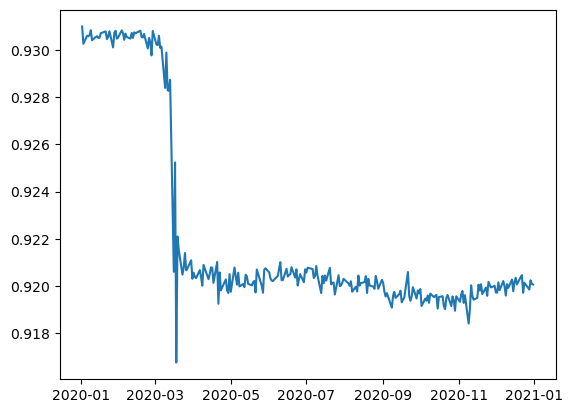

In [1095]:
plt.plot(df_t['spread'])

In [1098]:
df_t.head(5)

tic,SPTM,SCHX,kal_beta,stdev,spread,long entry,long exit,num units long,short entry,short exit,num units short,numUnits,spread pct ch,port rets,cum rets
Date,,,,,,,,,,,,,,,
2020-01-02,38.396206,37.069489,0.941199,0.052568,0.931002,False,False,0.0,False,False,0.0,0.0000,NaN,NaN,NaN
2020-01-03,38.166859,36.816017,0.940233,-0.037159,0.930267,True,False,1.0,False,True,0.0,0.9975,-1.010658e-05,-0.000000e+00,1.000000
2020-01-06,38.300652,36.954712,0.940561,0.012647,0.930611,False,True,0.0,True,False,-1.0,-0.9975,4.706682e-06,4.683178e-06,1.000005
2020-01-07,38.195530,36.863846,0.940771,0.008092,0.930587,False,False,0.0,False,False,-1.0,-0.9975,-3.298576e-07,3.282104e-07,1.000005
2020-01-08,38.357990,37.031231,0.941149,0.014602,0.930638,False,False,0.0,True,False,-1.0,-0.9975,6.942031e-07,-6.907365e-07,1.000004


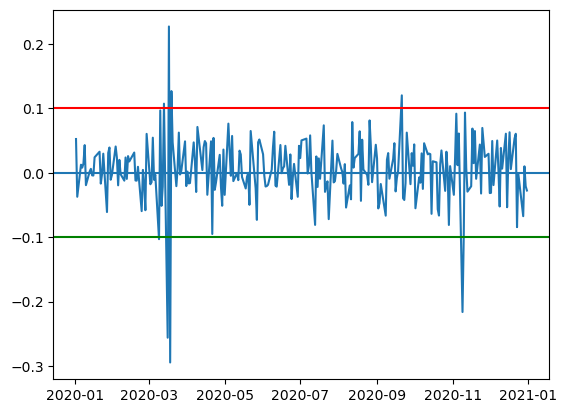

In [1119]:
pair

('DOG', 'SKF')

In [1196]:
#for pair in pair_list:

# df_f = np.log(df_form.loc[:, pair])
# df_t = np.log(df_trade.loc[:, pair])

pair = pair

df_f = df_form.loc[:, pair]
df_t = df_trade.loc[:, pair]

# df_f = np.log(df_form.loc[:, pair])
# df_t = np.log(df_trade.loc[:, pair])

#df_t[f'log_{pair[0]}'] = np.log(df_t[pair[0]])
#df_t[f'log_{pair[1]}'] = np.log(df_t[pair[1]])



delta = 1e-5
trans_cov = delta / (1-delta) * np.eye(2)
obs_mat = np.vstack([df_f[pair[0]], np.ones(len(df_f))]).T[:, np.newaxis]

kf = KalmanFilter(
    n_dim_obs=1, 
    n_dim_state=2,
    initial_state_mean=np.zeros(2),
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=1.0,
    transition_covariance=trans_cov
)

state_means, state_covs = kf.filter(df_f[pair[1]])

df_f['kal_beta'] = state_means[:,0]
df_f['spread'] = df_f[pair[1]] - df_f[pair[0]] * df_f['kal_beta']
df_f['stdev'] = df_f[pair[1]] - df_f[pair[0]] * state_means[:,0] - state_means[:,0].mean()

opt_reg = {}
for x in np.arange(0.01, 1, 0.01):
    opt_reg[x] = reg_sharpe_cal_std(df_f, x, 0)

opt_std = max(opt_reg, key=opt_reg.get)
state_means_new = []
state_means_new.append(state_means[-1])
state_covs_new = []
state_covs_new.append(state_covs[-1])
error_list = []
stdev_list = []

kal_beta_arr = list(state_means[:,0])
z_score_list = []
for num, idx in enumerate(df_t.index):

    # idx = df_t.index[0]
    new_price_1 = df_t.loc[idx, pair[0]]
    new_price_2 = df_t.loc[idx, pair[1]]

    my_error, my_stdev = getError(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])
    my_new_theta, my_new_R = getUpdate(state_means_new[-1], state_covs_new[-1], [new_price_1, new_price_2])

    state_means_new.append(my_new_theta)
    state_covs_new.append(my_new_R)
    error_list.append(my_error)
    stdev_list.append(my_stdev[0])

    tmp = pd.concat([df_f, df_t.loc[:idx]], axis=0)
    
    kal_beta_arr.append(state_means_new[-1][0])
    z_score = ((tmp[pair[1]] - tmp[pair[0]] * kal_beta_arr) - (tmp[pair[1]] - tmp[pair[0]] * kal_beta_arr).mean()) / (tmp[pair[1]] - tmp[pair[0]] * kal_beta_arr).std()
    z_score_list.append(z_score[-1])


df_t['kal_beta'] = kal_beta_arr[len(df_f):]
df_t['stdev'] = [x.item() for x in error_list]

df_t['spread'] = df_t[f'{pair[1]}'] - df_t[f'{pair[0]}'] * df_t['kal_beta'] #- df_t['kal_beta'] # + df_t['stdev']) #- df_t['kal_beta']
df_t['z'] = z_score_list

df_t = df_t.rename(columns={'kal_spread': 'spread', f'{pair[0]}' : 'x', f'{pair[1]}' : 'y', 'kal_beta':'hedge_ratio'})

reg_df_cal(df_t, 0.1, 0)
reg_sharpe_cal(df_t, 0.1, 0)

0.9732998492920414

In [1192]:
df_t

tic,IJR,SLY,kal_beta,stdev,spread,z
Date,,,,,,
2020-01-02,80.568161,69.899185,0.856939,-0.024978,0.857222,-0.003502
2020-01-03,80.520149,69.889542,0.857328,0.031389,0.857386,0.000530
2020-01-06,80.443329,69.754585,0.856471,-0.069048,0.857220,-0.003550
2020-01-07,79.982452,69.426826,0.857305,0.066862,0.857444,0.001974
2020-01-08,80.155296,69.619637,0.857862,0.044734,0.857415,0.001266
...,...,...,...,...,...,...
2020-12-24,89.756096,78.010170,0.859662,-0.057123,0.850224,-0.165410
2020-12-28,90.097305,78.186310,0.858363,-0.117256,0.850153,-0.167438
2020-12-29,88.556999,77.012047,0.860027,0.147734,0.850599,-0.153938


<AxesSubplot:xlabel='Date'>

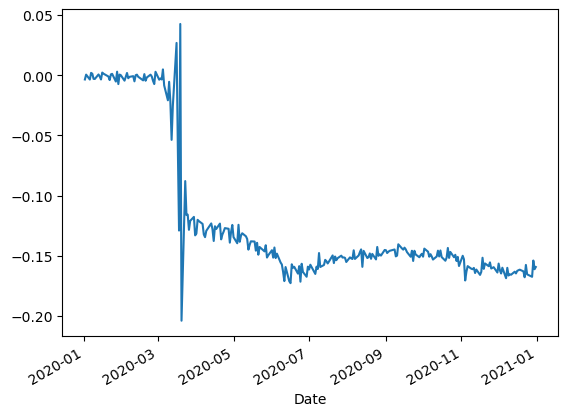

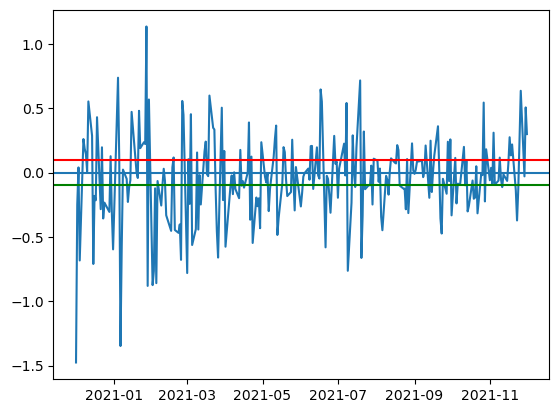

In [1126]:
plt.plot(df_t['stdev'])
plt.axhline(0.1, color='r')
plt.axhline(-0.1, color='g')
plt.axhline(0)

In [1128]:
'''spread는 y를 사고 x를 파는 것임 '''
entry = 0.1
exit = 0
tr = 0.0

In [1142]:
df_t

tic,DOG,SKF,kal_beta,stdev,spread,budget
Date,,,,,,
2020-12-01,40.279999,34.360001,0.818932,-1.475877,1.373421,100000
2020-12-02,40.180000,34.040001,0.812742,-0.250415,1.384022,100000
2020-12-03,40.080002,34.000000,0.813727,0.039741,1.385825,100000
2020-12-04,39.740002,33.040001,0.796661,-0.683088,1.380692,100000
2020-12-07,39.910000,33.439999,0.803140,0.260298,1.386699,100000
...,...,...,...,...,...,...
2021-11-24,32.330002,16.820000,0.479322,-0.128328,1.323527,100000
2021-11-26,33.130001,17.840000,0.498437,0.635340,1.326794,100000
2021-11-29,32.919998,17.700001,0.497546,-0.029650,1.320773,100000


In [1154]:
np.where(df_f['buy_spread_signal']==True, df_t['stdev'], np.NaN)

KeyError: 'buy_spread_signal'

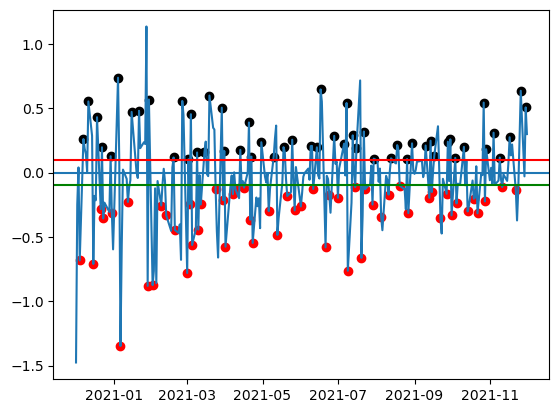

In [1156]:
plt.plot(df_t['stdev'])
plt.scatter(df_t.index, np.where(df_t['buy_spread_signal']==True, df_t['stdev'], np.NaN), color='r')
plt.scatter(df_t.index, np.where(df_t['sell_spread_signal']==True, df_t['stdev'], np.NaN), color='k')
plt.axhline(0.1, color='r')
plt.axhline(-0.1, color='g')
plt.axhline(0)

array([        nan,         nan,         nan, 39.74000168,         nan,
               nan,         nan,         nan,         nan,         nan,
       39.70000076,         nan,         nan,         nan, 39.70999908,
               nan, 39.81000137,         nan,         nan,         nan,
       39.40999985,         nan,         nan,         nan, 38.84999847,
               nan,         nan,         nan, 38.56000137,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan, 39.09000015,
               nan, 39.59000015,         nan,         nan,         nan,
               nan, 38.06000137,         nan,         nan,         nan,
       37.91999817,         nan,         nan,         nan, 37.86000061,
               nan,         nan,         nan,         nan,         nan,
       37.74000168,         nan, 38.04000092,         nan, 37.75999832,
               nan,         nan, 36.79000092,         nan, 36.22

In [1166]:
df_t.fillna(method='pad')

tic,DOG,SKF,kal_beta,stdev,spread,budget,buy_spread_signal,sell_spread_signal,buy_num,buy num,sell num,total num
Date,,,,,,,,,,,,
2020-12-01,40.279999,34.360001,0.818932,-1.475877,1.373421,100000,False,False,NaN,NaN,NaN,NaN
2020-12-02,40.180000,34.040001,0.812742,-0.250415,1.384022,100000,False,False,NaN,NaN,NaN,NaN
2020-12-03,40.080002,34.000000,0.813727,0.039741,1.385825,100000,False,False,NaN,NaN,NaN,NaN
2020-12-04,39.740002,33.040001,0.796661,-0.683088,1.380692,100000,True,False,1.0,1.0,NaN,NaN
2020-12-07,39.910000,33.439999,0.803140,0.260298,1.386699,100000,False,True,1.0,1.0,-1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-24,32.330002,16.820000,0.479322,-0.128328,1.323527,100000,False,False,1.0,1.0,-1.0,NaN
2021-11-26,33.130001,17.840000,0.498437,0.635340,1.326794,100000,False,True,1.0,1.0,-1.0,NaN
2021-11-29,32.919998,17.700001,0.497546,-0.029650,1.320773,100000,False,False,1.0,1.0,-1.0,NaN


In [1173]:
df_t['buy_spread_signal'] = (df_t['stdev'] < -entry) & (df_t['stdev'].shift(1) > -entry)
df_t['buy num'] = np.where(df_t['buy_spread_signal']==True, 1, np.nan)
df_t['buy num'][0] = 0
df_t['sell_spread_signal'] = (df_t['stdev'] > entry) & (df_t['stdev'].shift(1) < entry)
df_t['sell num'] = np.where(df_t['sell_spread_signal']==True, -1, np.nan)
df_t['sell num'][0] = 0
df_t = df_t.fillna(method='pad')

df_t['total num'] = df_t['buy num'] + df_t['sell num']

df_t



tic,DOG,SKF,kal_beta,stdev,spread,budget,buy_spread_signal,sell_spread_signal,buy num,sell num,total num
Date,,,,,,,,,,,
2020-12-01,40.279999,34.360001,0.818932,-1.475877,1.373421,100000,False,False,0.0,0.0,0.0
2020-12-02,40.180000,34.040001,0.812742,-0.250415,1.384022,100000,False,False,0.0,0.0,0.0
2020-12-03,40.080002,34.000000,0.813727,0.039741,1.385825,100000,False,False,0.0,0.0,0.0
2020-12-04,39.740002,33.040001,0.796661,-0.683088,1.380692,100000,True,False,1.0,0.0,1.0
2020-12-07,39.910000,33.439999,0.803140,0.260298,1.386699,100000,False,True,1.0,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-24,32.330002,16.820000,0.479322,-0.128328,1.323527,100000,False,False,1.0,-1.0,0.0
2021-11-26,33.130001,17.840000,0.498437,0.635340,1.326794,100000,False,True,1.0,-1.0,0.0
2021-11-29,32.919998,17.700001,0.497546,-0.029650,1.320773,100000,False,False,1.0,-1.0,0.0


[(-2, -1)]

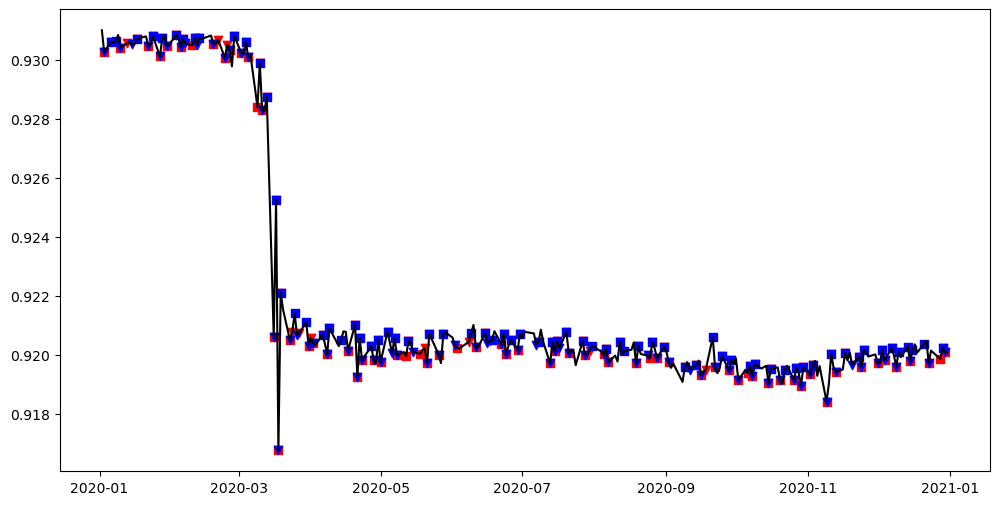

In [1030]:
plt.figure(figsize=(12,6))
plt.plot(df_t.spread, color='k')
plt.scatter(df_t.index, np.where(df_t['long entry'] == True, df_t.spread, np.NaN), marker='s', color='r', label='Long Entry')
plt.scatter(df_t.index, np.where(df_t['long exit'] == True, df_t.spread, np.NaN), marker='v', color='r',label='Long Exit')
plt.scatter(df_t.index, np.where(df_t['short entry'] == True, df_t.spread, np.NaN), marker='s', color='b', label='Short Entry')
plt.scatter(df_t.index, np.where(df_t['short exit'] == True, df_t.spread, np.NaN), marker='v', color='b', label='Short Exit')
plt.show()

# plt.figure(figsize=(20,10))
# plt.plot(df_t.spread, color='b')
# plt.scatter(df_t.index, np.where(df_t['long entry'] == True, df_t.spread, np.NaN), label='Long Entry')
# plt.scatter(df_t.index, np.where(df_t['long exit'] == True, df_t.spread, np.NaN), label='Long Exit')
# plt.scatter(df_t.index, np.where(df_t['short entry'] == True, df_t.spread, np.NaN), label='Short Entry')
# plt.scatter(df_t.index, np.where(df_t['short exit'] == True, df_t.spread, np.NaN), label='Short Exit')
# plt.show()



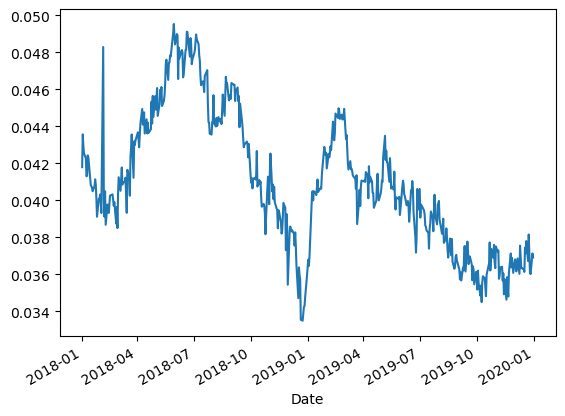

<AxesSubplot:xlabel='Date'>

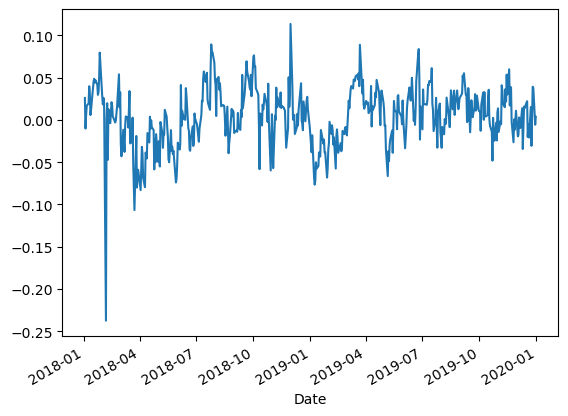

In [981]:
(df_f[pair[0]] / df_f[pair[1]] - 1).plot()
plt.show()
df_f.stdev.plot()

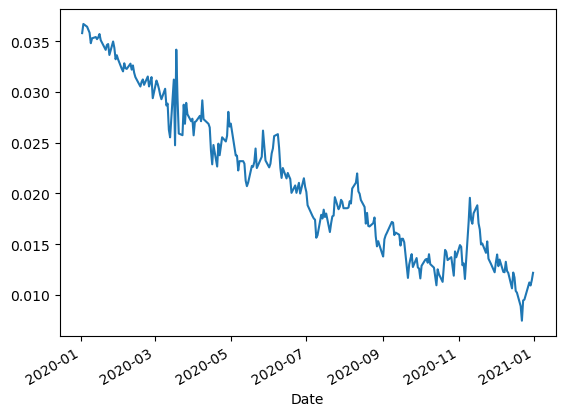

<AxesSubplot:xlabel='Date'>

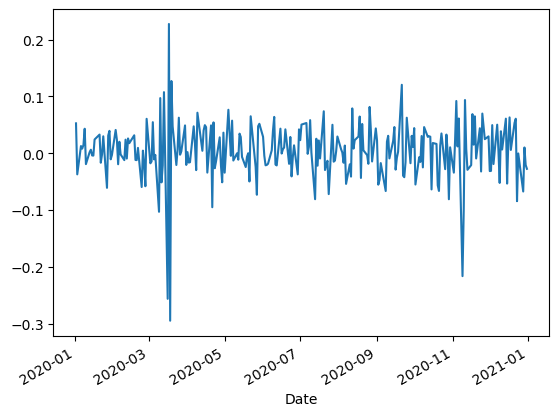

In [982]:
(df_t[pair[0]] / df_t[pair[1]] - 1).plot()
plt.show()
df_t.stdev.plot()

<AxesSubplot:xlabel='Date'>

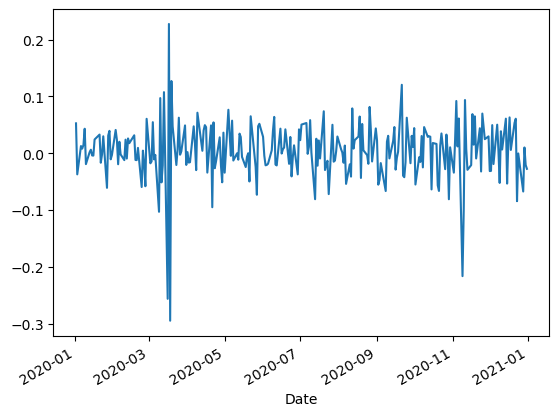

In [957]:
df_t.stdev.plot()

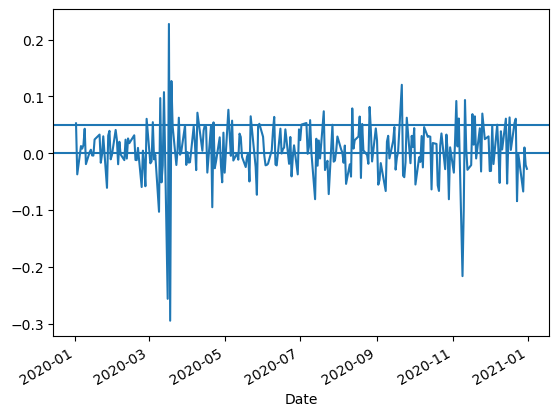

In [948]:
df_t.stdev.plot()
plt.axhline(0.05)
plt.axhline(0)

<AxesSubplot:xlabel='Date'>

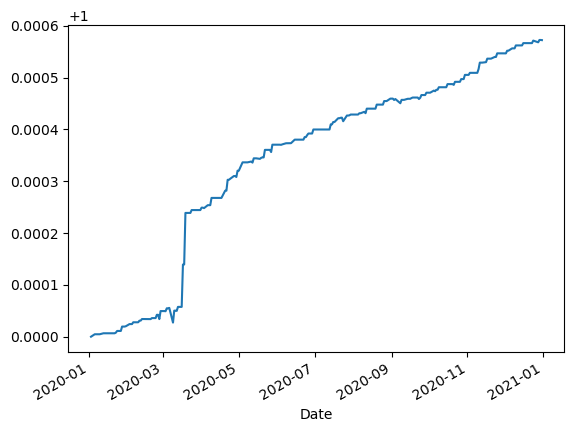

In [940]:
df_t['cum rets'].plot()

In [ ]:
def getError(theta, state_covs, latest_prices):

    vt = 1e-3
    P = np.zeros((2, 2))
    R = state_covs
    F = np.asarray([latest_prices[0], 1.0]).reshape((1, 2))
    y = latest_prices[1]
    yhat = F.dot(theta)
    et = y - yhat
    Qt = F.dot(R).dot(F.T) + vt
    sqrt_Qt = np.sqrt(Qt)
    return et, sqrt_Qt

In [961]:
state_means.mean()

0.9312548655266625

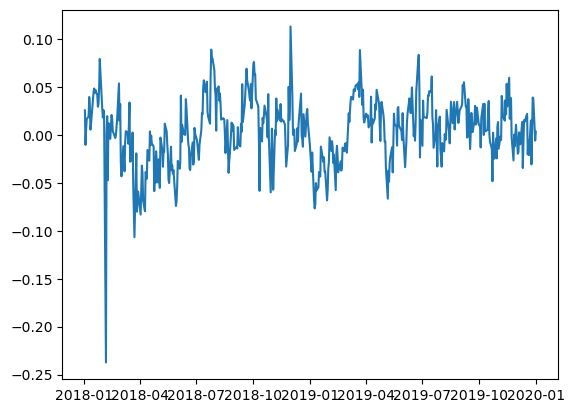

In [963]:
plt.plot(df_f[pair[1]] - df_f[pair[0]] * state_means[:,0] - state_means[:,0].mean())

<AxesSubplot:xlabel='Date'>

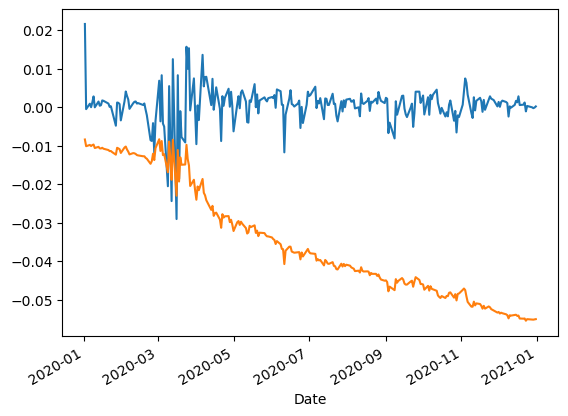

In [902]:
df_t['stdev'].plot()
df_t['spread'].plot()

In [881]:
getError()

TypeError: 'numpy.ndarray' object is not callable

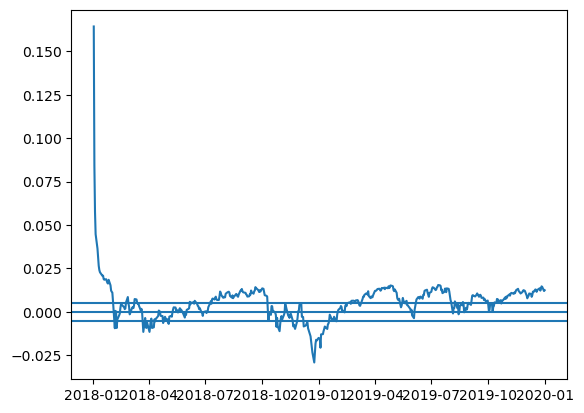

In [889]:
plt.plot(df_f[pair[1]] - df_f[pair[0]] * df_f['kal_beta'] - df_f['kal_beta'])


In [865]:
reg_df_cal_std(df_t, 0.005, 0)

tic,SPTM,SCHX,kal_beta,stdev,spread,long entry,long exit,num units long,short entry,short exit,num units short,numUnits,spread pct ch,port rets,cum rets
Date,,,,,,,,,,,,,,,
2020-01-02,3.647959,3.612794,0.779100,0.021575,0.770671,False,False,0.0,False,False,0.0,0.0,NaN,NaN,NaN
2020-01-03,3.641968,3.605933,0.779002,-0.000543,0.768832,False,False,0.0,False,True,0.0,0.0,-0.000286,-0.0,1.000000
2020-01-06,3.645467,3.609693,0.779154,0.000872,0.769313,False,True,0.0,False,False,0.0,0.0,0.000075,0.0,1.000000
2020-01-07,3.642718,3.607231,0.779147,-0.000042,0.769019,False,False,0.0,False,True,0.0,0.0,-0.000046,-0.0,1.000000
2020-01-08,3.646963,3.611762,0.779357,0.001210,0.769477,False,True,0.0,False,False,0.0,0.0,0.000071,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,3.793074,3.783590,0.800881,0.000277,0.745789,False,True,0.0,False,False,0.0,0.0,0.000066,0.0,1.008672
2020-12-28,3.800728,3.789564,0.800869,-0.000071,0.745680,False,False,0.0,False,True,0.0,0.0,-0.000016,-0.0,1.008672
2020-12-29,3.797892,3.787024,0.800819,-0.000290,0.745599,False,False,0.0,False,False,0.0,0.0,-0.000012,-0.0,1.008672


[]

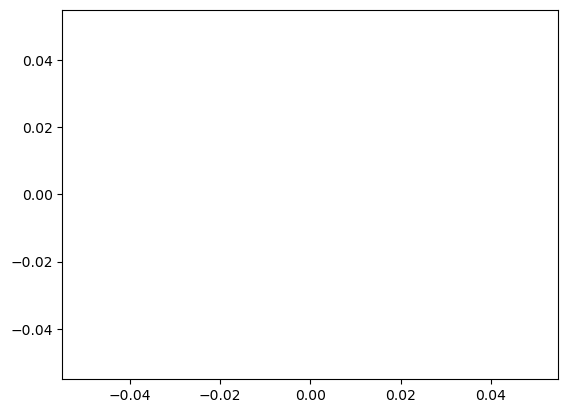

In [866]:
plt.plot()

In [859]:
reg_sharpe_cal_std(df_t, 0.005, 0)

2.1897943445981976

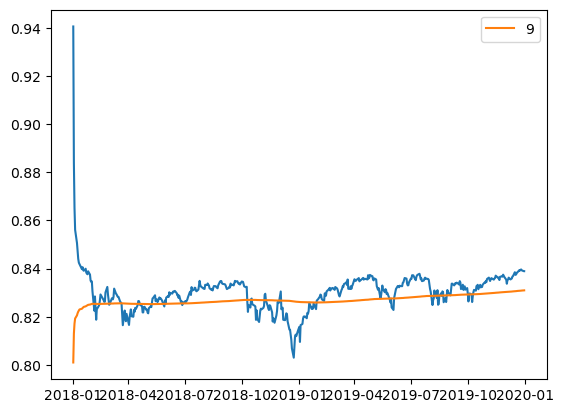

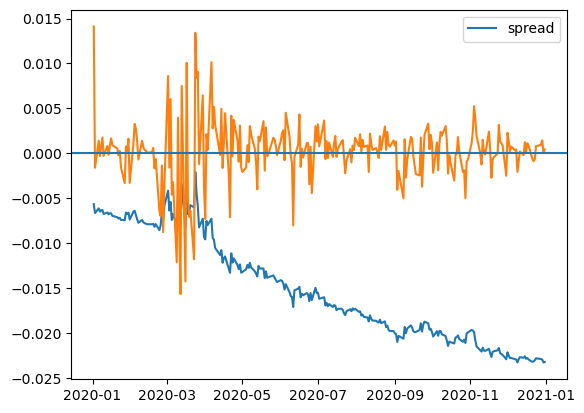

In [856]:
#(df_f[pair[0]] - df_f[pair[1]]).plot()
plt.plot(df_f[pair[1]] - state_means[:,0] * df_f[pair[0]])
plt.plot(df_f.index, state_means[:,0], label='9')
plt.legend()
plt.show()

#plt.plot(df_t.spread - df_t.kal_beta, label='spread')
plt.plot(df_t.stdev)
plt.axhline(0)
plt.legend()
plt.show()